In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # For Mac
plt.rcParams['axes.unicode_minus'] = False  # This is to display minus signs correctly



In [2]:
df_demand = pd.read_csv('./data/demand_train.csv',  encoding="gbk")
df_demand['过账日期'] = pd.to_datetime(df_demand['过账日期'])

df_demand.head(10)

,过账日期,需求量,工厂编码,物料编码,物料品牌,物料类型,物料品类
0,2018-01-06,0.33,2004,1000,5000,3002,4014
1,2018-01-08,0.09,2010,1000,5000,3002,4014
2,2018-01-09,0.09,2008,1000,5000,3002,4014
3,2018-01-10,0.10,2010,1000,5000,3002,4014
4,2018-01-11,0.17,2004,1000,5000,3002,4014
5,2018-01-13,0.06,2008,1000,5000,3002,4014
6,2018-01-15,0.45,2004,1000,5000,3002,4014
7,2018-01-18,0.03,2010,1000,5000,3002,4014
8,2018-01-19,0.06,2008,1000,5000,3002,4014
9,2018-01-20,0.84,2004,1000,5000,3002,4014


In [3]:
# 检查同日期+工厂+物料组合的重复
key_columns = ['过账日期', '工厂编码', '物料编码', '物料品牌', '物料类型', '物料品类']
date_factory_material_dups = df_demand[df_demand.duplicated(subset=key_columns, keep=False)]
df_demand = df_demand.groupby(key_columns)['需求量'].mean().reset_index()
date_factory_material_dups.head()

,过账日期,需求量,工厂编码,物料编码,物料品牌,物料类型,物料品类
10,2018-01-22,0.06,2008,1000,5000,3002,4014
11,2018-01-22,0.06,2008,1000,5000,3002,4014
33,2018-04-06,0.23,2004,1000,5000,3002,4014
34,2018-04-06,0.20,2004,1000,5000,3002,4014
35,2018-04-09,0.80,2004,1000,5000,3002,4014


In [4]:
df_demand['年月'] = df_demand['过账日期'].dt.to_period('M').astype(str)
df_demand['月'] = df_demand['年月'].str[-2:]
df_demand['季度'] = df_demand['过账日期'].dt.quarter
df_demand.head()

,过账日期,工厂编码,物料编码,物料品牌,物料类型,物料品类,需求量,年月,月,季度
0,2018-01-01,2001,1029,5001,3002,4006,1.29,2018-01,01,1
1,2018-01-01,2001,1051,5001,3002,4013,0.09,2018-01,01,1
2,2018-01-01,2001,1054,5001,3002,4010,0.70,2018-01,01,1
3,2018-01-01,2001,1159,5001,3003,4001,1.24,2018-01,01,1
4,2018-01-01,2001,1167,5001,3003,4023,6.40,2018-01,01,1


In [5]:
df_demand.drop(['过账日期', '物料品牌', '物料类型', '物料品类'], axis=1, inplace=True)
df_demand.head()

,工厂编码,物料编码,需求量,年月,月,季度
0,2001,1029,1.29,2018-01,01,1
1,2001,1051,0.09,2018-01,01,1
2,2001,1054,0.70,2018-01,01,1
3,2001,1159,1.24,2018-01,01,1
4,2001,1167,6.40,2018-01,01,1


In [6]:
q_low = df_demand['需求量'].quantile(0.025)
q_high = df_demand['需求量'].quantile(0.975)

df_demand = df_demand[(df_demand['需求量'] >= q_low) & (df_demand['需求量'] <= q_high)]

In [7]:
# 经分析 需求量与库存量、物料编码、工厂编码有很大可能存在关联性，考虑到最终预测是通过工厂编码 + 物料编码 进行预测的，故这里将数据进行预处理

df_demand['工厂编码_物料编码'] = df_demand['工厂编码'].astype(str) + '_' + df_demand['物料编码'].astype(str)
df_demand['年'] = df_demand['年月'].str[:4]
df_final = df_demand.groupby(['工厂编码_物料编码', '年月', '年', '月', '季度']).agg({'需求量': 'sum' }).reset_index()
df_final['年'] = df_final['年'].astype(int)
df_final['月'] = df_final['月'].astype(int)
df_final['季度'] = df_final['季度'].astype(int)
df_final.head()

,工厂编码_物料编码,年月,年,月,季度,需求量
0,2000_1001,2018-01,2018,1,1,12.530
1,2000_1001,2018-02,2018,2,1,16.080
2,2000_1001,2018-03,2018,3,1,3.125
3,2000_1001,2018-04,2018,4,2,8.780
4,2000_1001,2018-05,2018,5,2,3.142


In [8]:
all_codes = df_final['工厂编码_物料编码'].unique()
all_months = df_final['年月'].unique()

full_index = pd.MultiIndex.from_product(
    [all_codes, all_months],
    names=['工厂编码_物料编码', '年月']
)
df_final.set_index(['工厂编码_物料编码', '年月'], inplace=True)
df_final = df_final.reindex(full_index, fill_value=0).reset_index()
df_final.head()


,工厂编码_物料编码,年月,年,月,季度,需求量
0,2000_1001,2018-01,2018,1,1,12.530
1,2000_1001,2018-02,2018,2,1,16.080
2,2000_1001,2018-03,2018,3,1,3.125
3,2000_1001,2018-04,2018,4,2,8.780
4,2000_1001,2018-05,2018,5,2,3.142


In [9]:
def create_features(df, group_col='工厂编码_物料编码', target_col='需求量'):
    """
    创建滑动和滞后特征
    """
    # 按组排序
    df = df.sort_values([group_col, '年', '月'])
    
    # 创建滞后特征
    for lag in [1, 2, 3, 4, 5]:
        df[f'lag_{lag}'] = df.groupby(group_col)[target_col].shift(lag)
    
    
    # 创建基于滞后特征的滑动窗口特征
    for window in [2, 3, 4]:
        df[f's_l_roll_{window}_mean'] = df.groupby(group_col)['lag_1'].transform(
            lambda x: x.rolling(window=window).mean())
        df[f's_l_roll_{window}_max'] = df.groupby(group_col)['lag_1'].transform(
            lambda x: x.rolling(window=window).max())
        df[f's_l_roll_{window}_min'] = df.groupby(group_col)['lag_1'].transform(
            lambda x: x.rolling(window=window).min())
        df[f's_l_roll_{window}_std'] = df.groupby(group_col)['lag_1'].transform(
            lambda x: x.rolling(window=window).std())
        df[f's_l_roll_{window}_median'] = df.groupby(group_col)['lag_1'].transform(
            lambda x: x.rolling(window=window).median())
    
    return df

In [10]:

df_final = create_features(df_final)

df_final.head()
    

,工厂编码_物料编码,年月,年,月,季度,需求量,lag_1,lag_2,lag_3,lag_4,...,s_l_roll_3_mean,s_l_roll_3_max,s_l_roll_3_min,s_l_roll_3_std,s_l_roll_3_median,s_l_roll_4_mean,s_l_roll_4_max,s_l_roll_4_min,s_l_roll_4_std,s_l_roll_4_median
33,2000_1001,2018-08,0,0,0,0.000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,2000_1001,2020-08,0,0,0,0.000,0.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2000_1001,2018-01,2018,1,1,12.530,0.00,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000_1001,2018-02,2018,2,1,16.080,12.53,0.00,0.0,NaN,...,4.176667,12.53,0.0,7.234199,0.00,NaN,NaN,NaN,NaN,NaN
2,2000_1001,2018-03,2018,3,1,3.125,16.08,12.53,0.0,0.0,...,9.536667,16.08,0.0,8.447582,12.53,7.1525,16.08,0.0,8.385191,6.265


In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_final['工厂编码_物料编码'] = le.fit_transform(df_final['工厂编码_物料编码'])
df_final.head()

,工厂编码_物料编码,年月,年,月,季度,需求量,lag_1,lag_2,lag_3,lag_4,...,s_l_roll_3_mean,s_l_roll_3_max,s_l_roll_3_min,s_l_roll_3_std,s_l_roll_3_median,s_l_roll_4_mean,s_l_roll_4_max,s_l_roll_4_min,s_l_roll_4_std,s_l_roll_4_median
33,0,2018-08,0,0,0,0.000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,0,2020-08,0,0,0,0.000,0.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0,2018-01,2018,1,1,12.530,0.00,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2018-02,2018,2,1,16.080,12.53,0.00,0.0,NaN,...,4.176667,12.53,0.0,7.234199,0.00,NaN,NaN,NaN,NaN,NaN
2,0,2018-03,2018,3,1,3.125,16.08,12.53,0.0,0.0,...,9.536667,16.08,0.0,8.447582,12.53,7.1525,16.08,0.0,8.385191,6.265


In [12]:


# 划分训练集和测试集
df_train = df_final[df_final['年月'] < '2020-09']
df_test = df_final[df_final['年月'] >= '2020-09']
df_test.head()

,工厂编码_物料编码,年月,年,月,季度,需求量,lag_1,lag_2,lag_3,lag_4,...,s_l_roll_3_mean,s_l_roll_3_max,s_l_roll_3_min,s_l_roll_3_std,s_l_roll_3_median,s_l_roll_4_mean,s_l_roll_4_max,s_l_roll_4_min,s_l_roll_4_std,s_l_roll_4_median
30,0,2020-09,2020,9,3,1.800000,6.00,13.200000,3.968000,10.873333,...,7.722667,13.200000,3.968,4.851097,6.00,8.510333,13.200000,3.968,4.262679,8.436667
31,0,2020-10,2020,10,4,4.800000,1.80,6.000000,13.200000,3.968000,...,7.000000,13.200000,1.800,5.765414,6.00,6.242000,13.200000,1.800,4.945529,4.984000
32,0,2020-11,2020,11,4,8.400000,4.80,1.800000,6.000000,13.200000,...,4.200000,6.000000,1.800,2.163331,4.80,6.450000,13.200000,1.800,4.834253,5.400000
65,1,2020-09,2020,9,3,39.560000,13.72,49.286667,48.320000,59.673333,...,37.108889,49.286667,13.720,20.261138,48.32,42.750000,59.673333,13.720,20.024094,48.803333
66,1,2020-10,2020,10,4,73.013333,39.56,13.720000,49.286667,48.320000,...,34.188889,49.286667,13.720,18.381610,39.56,37.721667,49.286667,13.720,16.588484,43.940000


In [13]:
#  训练模型
features = [col for col in df_final.columns if col not in ['工厂编码_物料编码', '年月', '需求量']]
target = '需求量'

print(features)
X_train, y_train = df_train[features], df_train[target]
X_test, y_test = df_test[features], df_test[target]


['年', '月', '季度', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 's_l_roll_2_mean', 's_l_roll_2_max', 's_l_roll_2_min', 's_l_roll_2_std', 's_l_roll_2_median', 's_l_roll_3_mean', 's_l_roll_3_max', 's_l_roll_3_min', 's_l_roll_3_std', 's_l_roll_3_median', 's_l_roll_4_mean', 's_l_roll_4_max', 's_l_roll_4_min', 's_l_roll_4_std', 's_l_roll_4_median']


In [14]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV


model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    boosting_type='goss',
    random_state=42
)
eval_result = {}  # 用于保存评估结果


model.fit(
    X_train,
    y_train, 
    eval_set=[(X_test, y_test)],  # 监控训练集误差
    eval_metric='l2',  # 使用MSE（L2损失）
    callbacks=[lgb.record_evaluation(eval_result)],  # 记录评估结果
    )

# 提取训练误差数据
# train_error = eval_result['valid_0']['l2']

# # 绘制训练误差曲线
# plt.figure(figsize=(10, 6))
# plt.plot(train_error, label='Training Error (MSE)')
# plt.title('Training Error vs. Boosting Iterations')
# plt.xlabel('Boosting Iterations')
# plt.ylabel('Mean Squared Error')
# plt.legend()
# plt.grid(True)
# plt.show()

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5122
[LightGBM] [Info] Number of data points in the train set: 30464, number of used features: 23
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Start training from score

LGBMRegressor(boosting_type='goss', colsample_bytree=0.8, learning_rate=0.05,
              n_estimators=500, objective='regression', random_state=42,
              subsample=0.8)

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. 对测试集进行预测
y_test_pred = model.predict(df_test[features])

# 2. 计算评估指标
mse = mean_squared_error(df_test[target], y_test_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(df_test[target], y_test_pred)
r2 = r2_score(df_test[target], y_test_pred)


# 打印结果
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")

print(y_test_pred)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
MSE: 67.1717
MAE: 3.3909
[ 6.4096819   4.21260829  5.58690464 ... -0.00878313 -0.00878313
 -0.00878313]


In [16]:
df_predict_lgb = df_test.copy()
df_predict_lgb['预测值'] = y_test_pred  # 添加预测值列

# 2. 计算绝对差异和相对差异
df_predict_lgb['绝对差异'] = df_predict_lgb['预测值'] - df_predict_lgb['需求量']
df_predict_lgb['相对差异(%)'] = (df_predict_lgb['绝对差异'] / df_predict_lgb['需求量']).abs() * 100


df_predict_lgb.head()

,工厂编码_物料编码,年月,年,月,季度,需求量,lag_1,lag_2,lag_3,lag_4,...,s_l_roll_3_std,s_l_roll_3_median,s_l_roll_4_mean,s_l_roll_4_max,s_l_roll_4_min,s_l_roll_4_std,s_l_roll_4_median,预测值,绝对差异,相对差异(%)
30,0,2020-09,2020,9,3,1.800000,6.00,13.200000,3.968000,10.873333,...,4.851097,6.00,8.510333,13.200000,3.968,4.262679,8.436667,6.409682,4.609682,256.093439
31,0,2020-10,2020,10,4,4.800000,1.80,6.000000,13.200000,3.968000,...,5.765414,6.00,6.242000,13.200000,1.800,4.945529,4.984000,4.212608,-0.587392,12.237327
32,0,2020-11,2020,11,4,8.400000,4.80,1.800000,6.000000,13.200000,...,2.163331,4.80,6.450000,13.200000,1.800,4.834253,5.400000,5.586905,-2.813095,33.489230
65,1,2020-09,2020,9,3,39.560000,13.72,49.286667,48.320000,59.673333,...,20.261138,48.32,42.750000,59.673333,13.720,20.024094,48.803333,12.150427,-27.409573,69.286079
66,1,2020-10,2020,10,4,73.013333,39.56,13.720000,49.286667,48.320000,...,18.381610,39.56,37.721667,49.286667,13.720,16.588484,43.940000,34.551811,-38.461522,52.677395


In [17]:
# 3. 按绝对差异排序（可选）
df_compare_lgb = df_predict_lgb.sort_values(by='相对差异(%)', key=abs, ascending=False)

# 4. 显示关键列（按需调整显示的列）
columns_to_show = ['工厂编码_物料编码', '年月', '需求量', '预测值', '绝对差异', '相对差异(%)']
df_compare_lgb = df_compare_lgb[columns_to_show]

# 5. 格式化输出（保留两位小数）
pd.options.display.float_format = '{:.2f}'.format
print("预测值与真实值对比表：")
df_compare_lgb.head(10)  # 显示差异最大的前10条样本

预测值与真实值对比表：


,工厂编码_物料编码,年月,需求量,预测值,绝对差异,相对差异(%)
16691,476,2020-10,0.00,-0.01,-0.01,inf
18720,534,2020-09,0.00,-0.01,-0.01,inf
18967,541,2020-11,0.00,-0.01,-0.01,inf
18966,541,2020-10,0.00,-0.01,-0.01,inf
18965,541,2020-09,0.00,-0.01,-0.01,inf
18897,539,2020-11,0.00,-0.01,-0.01,inf
18896,539,2020-10,0.00,-0.01,-0.01,inf
18895,539,2020-09,0.00,-0.01,-0.01,inf
18862,538,2020-11,0.00,-0.01,-0.01,inf
18861,538,2020-10,0.00,-0.01,-0.01,inf


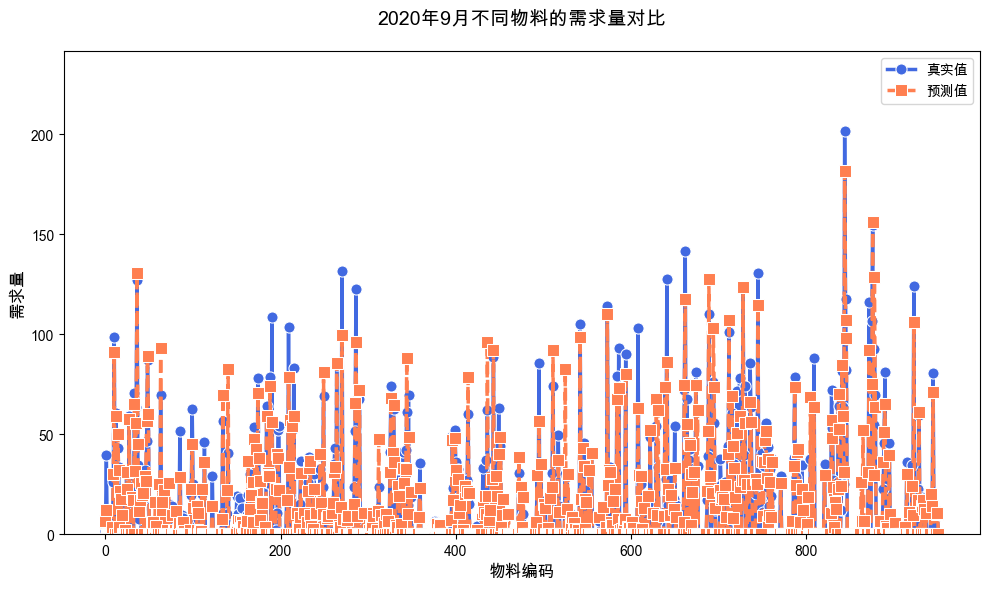

In [18]:
df_test_lgb_9 = df_predict_lgb[(df_test['年月'] == '2020-09')]
plt.figure(figsize=(10, 6))

# 绘制折线图（带标记点）
lineplot = sns.lineplot(
    data=df_test_lgb_9,
    x='工厂编码_物料编码',
    y='需求量',
    marker='o',
    markersize=8,
    linewidth=2.5,
    color='royalblue',
    label='真实值'
)
sns.lineplot(
    data=df_test_lgb_9,
    x='工厂编码_物料编码',
    y='预测值',
    marker='s',
    markersize=8,
    linewidth=2.5,
    color='coral',
    linestyle='--',
    label='预测值'
)

plt.title('2020年9月不同物料的需求量对比', fontsize=14, pad=20)
plt.xlabel('物料编码', fontsize=12)
plt.ylabel('需求量', fontsize=12)

# 调整Y轴范围（考虑数值差异大的情况）
plt.ylim(0, df_test_lgb_9['需求量'].max() * 1.2)

# 显示图表
plt.tight_layout()
plt.show()

In [19]:
# ==================== 滚动预测 ====================
def rolling_forecast(model, df_history, features, forecast_months=3):
    # 复制历史数据
    df_future = df_history.copy()
    
    # 生成预测时间范围
    last_date = pd.to_datetime(df_future['年月'].max())
    date_range = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                              periods=forecast_months, 
                              freq='MS')
    
    print(date_range)

    for forecast_date in date_range:
        for group in df_future['工厂编码_物料编码'].unique():
            new_row = {
                '年月': forecast_date.strftime('%Y-%m'),
                '年': forecast_date.year,
                '月': forecast_date.month,
                '季度': (forecast_date.month - 1) // 3 + 1,
                '需求量': np.nan,
                '工厂编码_物料编码': group  # 确保分组标识符被包含
            }
            # 添加新记录
            df_future = pd.concat([df_future, pd.DataFrame([new_row])], ignore_index=True)

        # 重新计算滑动窗口特征
        df_future = create_features(df_future)

        df_need_predict = df_future[df_future['年月']  == forecast_date.strftime('%Y-%m')]

        df_need_predict['需求量'] = model.predict(df_need_predict[features])

        df_future.update(df_need_predict)
    
    # 返回预测结果
    return df_future[df_future['年月'].isin([date.strftime('%Y-%m') for date in date_range])], df_future




In [20]:
future_predictions, future_predictions_all = rolling_forecast(model, 
                                        df_final, 
                                        features,
                                        forecast_months=3)



DatetimeIndex(['2020-12-01', '2021-01-01', '2021-02-01'], dtype='datetime64[ns]', freq='MS')
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


/var/folders/v5/g47_227965503jwr64326bnw0000gn/T/ipykernel_41806/2279154671.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_need_predict['需求量'] = model.predict(df_need_predict[features])


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


/var/folders/v5/g47_227965503jwr64326bnw0000gn/T/ipykernel_41806/2279154671.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_need_predict['需求量'] = model.predict(df_need_predict[features])


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


/var/folders/v5/g47_227965503jwr64326bnw0000gn/T/ipykernel_41806/2279154671.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_need_predict['需求量'] = model.predict(df_need_predict[features])


In [21]:
future_predictions['工厂编码_物料编码'] = le.inverse_transform(future_predictions['工厂编码_物料编码'])
future_predictions_all['工厂编码_物料编码'] = le.inverse_transform(future_predictions_all['工厂编码_物料编码'])



/var/folders/v5/g47_227965503jwr64326bnw0000gn/T/ipykernel_41806/2402685685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_predictions['工厂编码_物料编码'] = le.inverse_transform(future_predictions['工厂编码_物料编码'])


In [29]:
def plotPrediction():

  unique_codes = future_predictions_all['工厂编码_物料编码'].unique()
    
  random_codes = np.random.choice(unique_codes, size=min(10, len(unique_codes)), replace=False)
    
  random_samples = future_predictions_all[future_predictions_all['工厂编码_物料编码'].isin(random_codes)].copy()

  random_samples.sort_values(by=['工厂编码_物料编码', '年月'], inplace=True)

  plt.figure(figsize=(10, 6))

  lineplot = sns.lineplot(
      data=random_samples,
      x='年月',
      y='需求量',
      marker='o',
      hue='工厂编码_物料编码',
      linewidth=2,
      palette='tab10',
      markersize=8,
  )

  plt.title('工厂编码_物料编码的预测需求量', fontsize=14)
  plt.xlabel('年月', fontsize=12)
  plt.ylabel('需求量', fontsize=12)

  plt.ylim(0, random_samples['需求量'].max() * 1.8)
  plt.xticks(rotation=45)
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

  # 显示图表
  plt.tight_layout()
  plt.show()
  return random_samples

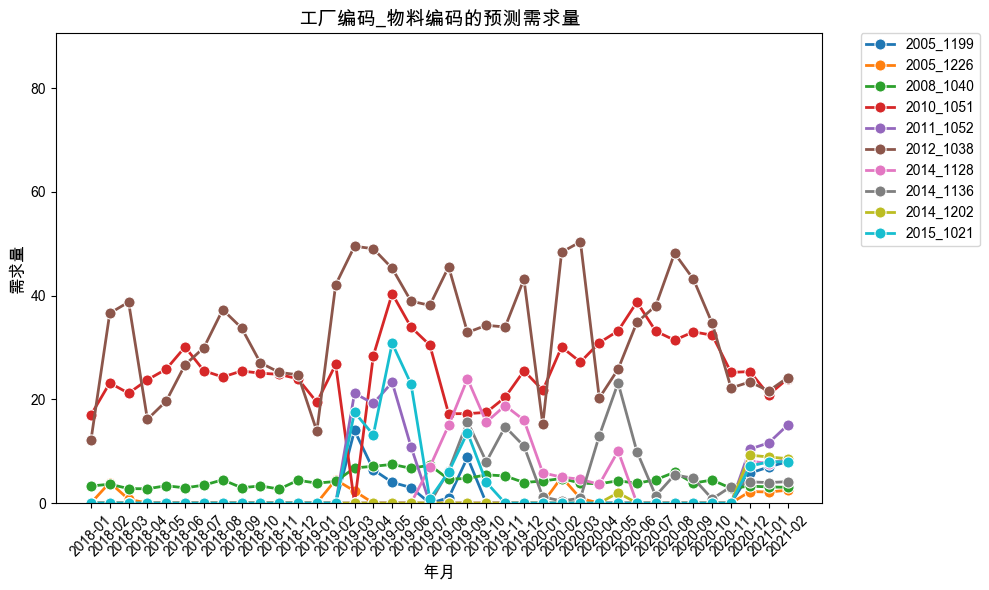

In [30]:
random_samples = plotPrediction()

In [28]:
random_samples.head()

,工厂编码_物料编码,年月,年,月,季度,需求量,lag_1,lag_2,lag_3,lag_4,...,s_l_roll_3_mean,s_l_roll_3_max,s_l_roll_3_min,s_l_roll_3_std,s_l_roll_3_median,s_l_roll_4_mean,s_l_roll_4_max,s_l_roll_4_min,s_l_roll_4_std,s_l_roll_4_median
999,2000_1054,2018-01,2018,1,1,78.20,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,2000_1054,2018-02,2018,2,1,89.44,78.20,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,2000_1054,2018-03,2018,3,1,52.59,89.44,78.20,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,2000_1054,2018-04,2018,4,2,41.77,52.59,89.44,78.20,NaN,...,73.41,89.44,52.59,18.88,78.20,NaN,NaN,NaN,NaN,NaN
1003,2000_1054,2018-05,2018,5,2,39.25,41.77,52.59,89.44,78.20,...,61.27,89.44,41.77,24.99,52.59,65.50,89.44,41.77,22.09,65.40


In [24]:
# 还原工厂编码_物料编码 
future_predictions.sort_values(by=['工厂编码_物料编码'], inplace=True)

future_predictions.head()




/var/folders/v5/g47_227965503jwr64326bnw0000gn/T/ipykernel_41806/2395939361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_predictions.sort_values(by=['工厂编码_物料编码'], inplace=True)


,工厂编码_物料编码,年月,年,月,季度,需求量,lag_1,lag_2,lag_3,lag_4,...,s_l_roll_3_mean,s_l_roll_3_max,s_l_roll_3_min,s_l_roll_3_std,s_l_roll_3_median,s_l_roll_4_mean,s_l_roll_4_max,s_l_roll_4_min,s_l_roll_4_std,s_l_roll_4_median
35,2000_1001,2020-12,2020,12,4,10.26,8.40,4.80,1.80,6.00,...,5.00,8.40,1.80,3.30,4.80,5.25,8.40,1.80,2.74,5.40
36,2000_1001,2021-01,2021,1,1,8.29,10.26,8.40,4.80,1.80,...,7.82,10.26,4.80,2.78,8.40,6.31,10.26,1.80,3.77,6.60
35224,2000_1001,2021-02,2021,2,1,9.02,8.29,10.26,8.40,4.80,...,8.98,10.26,8.29,1.11,8.40,7.94,10.26,4.80,2.28,8.35
72,2000_1003,2020-12,2020,12,4,38.18,39.23,73.01,39.56,13.72,...,50.60,73.01,39.23,19.41,39.56,41.38,73.01,13.72,24.32,39.39
73,2000_1003,2021-01,2021,1,1,21.93,38.18,39.23,73.01,39.56,...,50.14,73.01,38.18,19.82,39.23,47.50,73.01,38.18,17.02,39.39


In [25]:
# 转为 工厂编码	物料编码	M+1月预测需求量	M+2月预测需求量	M+3月预测需求量

predict_pd = future_predictions.copy()

predict_pd[['工厂编码', '物料编码']] = predict_pd['工厂编码_物料编码'].str.split('_', expand=True)

predict_pd_pivot = predict_pd.pivot_table(
    index=['工厂编码', '物料编码'],  # 唯一键
    columns='年月',                # 要转成列的字段
    values='需求量',               # 要填充的值
    aggfunc='first'              # 如果有重复，取第一个
).reset_index()

# 重命名列
predict_pd_pivot.columns = [
    '工厂编码', 
    '物料编码', 
    'M+1月预测需求量',  # 2020-12
    'M+2月预测需求量',  # 2021-01
    'M+3月预测需求量'   # 2021-02
]

predict_pd_pivot.sort_values(by=['工厂编码', '物料编码'], inplace=True)

predict_pd_pivot.head()



,工厂编码,物料编码,M+1月预测需求量,M+2月预测需求量,M+3月预测需求量
0,2000,1001,10.26,8.29,9.02
1,2000,1003,38.18,21.93,21.50
2,2000,1006,6.54,11.50,18.95
3,2000,1010,2.02,3.08,5.47
4,2000,1014,8.60,7.05,8.39
